# KOMO: Motion Optimization

KOMO is a framework for designing motion by formulating optimization problems. Inverse kinematics (IK) is the special case of optimizing only over a single configuration rather than a path. Formulating KOMO problems is key to realizing motion in `rai`.

This tutorial shows basics on how IK, rough waypoint optimization, and fine path optimization can be formulated as non-linear mathematical program (NLP) using KOMO. Essentially, the `addObjective` allows to add costs or constraints over any `Feature` to the NLP (same features that can be evaluated with 'C.eval').

## Minimal IK example

In [1]:
from robotic import ry
import numpy as np
import time

In [2]:
C = ry.Config()
C.addFile(ry.raiPath('scenarios/pandaSingle.g'))
C.view()

0

In [3]:
C.addFrame('box') \
    .setPosition([-.25,.1,1.]) \
    .setShape(ry.ST.ssBox, size=[.06,.06,.06,.005]) \
    .setColor([1,.5,0]) \
    .setContact(1)
C.view()

0

The following defines an optimization problem over a single configuration. The KOMO object essentially contains (1) a copy of the configuration(s) over which we optimize, and (2) the list of objectives (=costs & constraints) that define the optimization problem.

The constructor declares over how many configurations (single, waypoints, path..) we optimize. The addObjective methods add costs or constraints:

In [4]:
qHome = C.getJointState()

komo = ry.KOMO(C, 1, 1, 0, False)
komo.addObjective(times=[], feature=ry.FS.jointState, frames=[], type=ry.OT.sos, scale=[1e-1], target=qHome);
komo.addObjective([], ry.FS.positionDiff, ['l_gripper', 'box'], ry.OT.eq, [1e1]);

We explain the KOMO constructor arguments later. (The above defines an IK problem.)

The `addObjective` method has signature
* times: the time intervals (subset of configurations in a path) over which this feature is active (irrelevant for IK)
* feature: the feature symbol (see advanced `Feature` tutorial)
* frames: the frames for which the feature is computed, given as list of frame names
* type: whether this is a sum-of-squares (sos) cost, or eq or ineq constraint
* scale: the matrix(!) by which the feature is multiplied
* target: the offset which is substracted from the feature (before scaling)

Please see more formal details <here - link to script!>

Given this definition of an optimization problem, we can call a generic NLP solver:

In [5]:
ret = ry.NLP_Solver(komo.nlp(), verbose=4) .solve()
print(ret)

{ time: 0.001417, evals: 6, done: 1, feasible: 1, sos: 0.00414146, f: 0, ineq: 0, eq: 0.00188382 }====nlp==== method:AugmentedLagrangian bounded: yes
==nlp== it:0 evals:0 mu:1 nu:1 muLB:0.1
----newton---- initial point f(x):16.0447 alpha:1 beta:1
--newton-- it:   1  |Delta|:        0.2  alpha:          1  evals:   2  f(y):    6.55808  ACCEPT
--newton-- it:   2  |Delta|:        0.2  alpha:          1  evals:   3  f(y):   0.686083  ACCEPT
--newton-- it:   3  |Delta|:   0.144223  alpha:          1  evals:   4  f(y):  0.0170221  ACCEPT
--newton-- it:   4  |Delta|:  0.0221449  alpha:          1  evals:   5  f(y): 0.00418093  ACCEPT
--newton-- stopping: 'absMax(Delta)<options.stopTolerance'
==nlp== it:   0  evals:   5  A(x): 0.00418093  f: 0.00414937  g:          0  h: 0.00951471  |x-x'|:   0.373024 	stop:DeltaConverge
==nlp== it:   1  evals:   5  A(x): 0.00437027  mu:5
--newton-- it:   5  |Delta|: 0.00240133  alpha:          1  evals:   6  f(y): 0.00413537  ACCEPT
--newton-- stopping: 'absM

With this high verbosity, individual newton steps and Augmented Lagrangian outer loops are displayed (we need only very few steps here).

The KOMO view displays the optimized configuration(s) stored by KOMO. (For paths, this is an overlay of many configurations. For IK, just one.):

In [6]:
komo.view(False, "IK solution")

0

We can get the sequence of joint state vectors for the optimized configuration(s) with `getPath`. Since this is only an IK problem, the sequence contains only the joint state vector for the single optimized configuration:

In [7]:
q = komo.getPath()
print(type(q), len(q))

<class 'numpy.ndarray'> 1


We're done with KOMO and can destroy it. Then set the optimal joint state in C and view it:

In [8]:
del komo #also closes komo view
C.setJointState(q[0])
C.view()

86

## Example for more constraints: box grasping IK

The key to design motions is to add clever constraints. Here is an example for more realistic box grasping:

In [9]:
komo = ry.KOMO(C, 1,1,0, True)
komo.addObjective([], ry.FS.jointState, [], ry.OT.sos, [1e-1], qHome)
komo.addObjective([], ry.FS.accumulatedCollisions, [], ry.OT.eq)
komo.addObjective([], ry.FS.jointLimits, [], ry.OT.ineq)
komo.addObjective([], ry.FS.positionDiff, ['l_gripper', 'box'], ry.OT.eq, [1e1])
komo.addObjective([], ry.FS.scalarProductXX, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])
komo.addObjective([], ry.FS.scalarProductXZ, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])
komo.addObjective([], ry.FS.distance, ['l_palm', 'box'], ry.OT.ineq, [1e1])

The two `scalarProduct` feature state that the gripper x-axis (which is the axis connecting the fingers) should be orthogonal to the object x- and z-axes. That implies fingers to normally oppose the object's y-planes.

Note that grasping could also be opposing the object x- or z- planes -- see below. Let solve it and then set the joint state to the solution:

In [11]:
ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
print(ret)
if ret.feasible:
    print('-- Always check feasibility flag of NLP solver return')
else:
    print('-- THIS IS INFEASIBLE!')

{ time: 0.001427, evals: 3, done: 1, feasible: 1, sos: 0.00551937, f: 0, ineq: 0, eq: 0.000566221 }
-- Always check feasibility flag of NLP solver return


In [12]:
q = komo.getPath()
C.setJointState(q[0])
C.view(False, "IK solution")

13

Reusing the KOMO instance is ok if some aspect of the configuration changes and you want to resolve the same problem:

In [15]:
box = C.getFrame('box')
box.setPosition([-.25,.1,1.])
p0 = box.getPosition() # memory the start box position

for t in range(10):
    box.setPosition(p0 + .2 * np.random.randn(3)) # randomize box position
    komo.updateRootObjects(C) # only works for root objects (the 'box' is one)
    ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
    print(ret)
    q = komo.getPath()
    C.setJointState(q[0])
    C.view(False, 'IK solution - ' + ('*** INFEASIBLE ***' if not ret.feasible else 'feasible'))
    time.sleep(1.)

{ time: 0.028821, evals: 70, done: 1, feasible: 1, sos: 0.038482, f: 0, ineq: 0, eq: 0.0689135 }
{ time: 0.030648, evals: 57, done: 1, feasible: 1, sos: 0.0228804, f: 0, ineq: 0, eq: 0.000608482 }
{ time: 0.016176, evals: 23, done: 1, feasible: 1, sos: 0.0184499, f: 0, ineq: 0, eq: 0.000537333 }
{ time: 0.023501, evals: 70, done: 1, feasible: 1, sos: 0.0298244, f: 0, ineq: 0, eq: 0.000128193 }
{ time: 0.043527, evals: 76, done: 1, feasible: 1, sos: 0.0325442, f: 0, ineq: 0, eq: 0.000223303 }
{ time: 0.013276, evals: 21, done: 1, feasible: 1, sos: 0.0597724, f: 0, ineq: 0, eq: 0.00114935 }
{ time: 0.029548, evals: 52, done: 1, feasible: 1, sos: 0.0106994, f: 0, ineq: 0, eq: 0.000153658 }
{ time: 0.004645, evals: 8, done: 1, feasible: 1, sos: 0.0140415, f: 0, ineq: 0, eq: 0.00139689 }
{ time: 0.012348, evals: 16, done: 1, feasible: 1, sos: 0.00865087, f: 0, ineq: 0, eq: 0.000584601 }
{ time: 0.01036, evals: 14, done: 1, feasible: 1, sos: 0.0232755, f: 0, ineq: 0, eq: 0.000568126 }


So the solver finds feasible grasps and exploits the null space of the constraints (grasps from different directions, but always opposing the y-planes).

To make this proper, we should actually test all three possible grasps - so let's define 3 IK problems, solve each, and pick the best:

In [16]:
del komo
komo = []
for k in range(3):
    komo.append(ry.KOMO(C, 1,1,0, True))
    komo[k].addObjective([], ry.FS.jointState, [], ry.OT.sos, [1e-1], qHome)
    komo[k].addObjective([], ry.FS.accumulatedCollisions, [], ry.OT.eq)
    komo[k].addObjective([], ry.FS.jointLimits, [], ry.OT.ineq)
    komo[k].addObjective([], ry.FS.positionDiff, ['l_gripper', 'box'], ry.OT.eq, [1e1])
    komo[k].addObjective([], ry.FS.distance, ['l_palm', 'box'], ry.OT.ineq, [1e1])

komo[0].addObjective([], ry.FS.scalarProductXY, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])
komo[0].addObjective([], ry.FS.scalarProductXZ, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])

komo[1].addObjective([], ry.FS.scalarProductXX, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])
komo[1].addObjective([], ry.FS.scalarProductXZ, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])

komo[2].addObjective([], ry.FS.scalarProductXX, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])
komo[2].addObjective([], ry.FS.scalarProductXY, ['l_gripper', 'box'], ry.OT.eq, [1e1], [0])

In [18]:
for t in range(10):
    box.setPosition(p0 + .2 * np.random.randn(3))
    box.setQuaternion(np.random.randn(4)) # also set random orientation (quaternions get internally normalized)
    
    score = []
    for k in range(3):
        komo[k].updateRootObjects(C)
        ret = ry.NLP_Solver(komo[k].nlp(), verbose=0 ) .solve()
        score.append( 100.*(ret.eq+ret.ineq) + ret.sos )
        
    k = np.argmin(score)
    C.setJointState(komo[k].getPath()[0])
    C.view(False, f'IK solution {k} - ' + ('*** INFEASIBLE ***' if not ret.feasible else 'feasible'))
    time.sleep(1.)

In [19]:
del komo
del C

## Waypoints example

Motion design can often be done by computing waypoints, i.e. a none-fine-resolution sequence of poses. The BotOp interface can then spline-interpolate between them when executing them.

Let's define a configuration where the desired gripper waypoints are pre-defined as marker frames. (That's a common pattern: Simplify defining constraints by adding helper reference frames in the configuration.)

In [20]:
C = ry.Config()
C.addFile(ry.raiPath('scenarios/pandaSingle.g'))
C.addFrame('way1'). setShape(ry.ST.marker, [.1]) .setPosition([.4, .2, 1.])
C.addFrame('way2'). setShape(ry.ST.marker, [.1]) .setPosition([.4, .2, 1.4])
C.addFrame('way3'). setShape(ry.ST.marker, [.1]) .setPosition([-.4, .2, 1.])
C.addFrame('way4'). setShape(ry.ST.marker, [.1]) .setPosition([-.4, .2, 1.4])
C.view()

0

Now we can define a KOMO problem over 4 configurations, where at each configuration we impose position equality between gripper and a waypoint:

In [26]:
komo = ry.KOMO(C, phases=4, slicesPerPhase=1, kOrder=1, enableCollisions=False)
komo.addControlObjective([], 0, 1e-1)
komo.addControlObjective([], 1, 1e0)
komo.addObjective([1], ry.FS.positionDiff, ['l_gripper', 'way1'], ry.OT.eq, [1e1])
komo.addObjective([2], ry.FS.positionDiff, ['l_gripper', 'way2'], ry.OT.eq, [1e1])
komo.addObjective([3], ry.FS.positionDiff, ['l_gripper', 'way3'], ry.OT.eq, [1e1])
komo.addObjective([4], ry.FS.positionDiff, ['l_gripper', 'way4'], ry.OT.eq, [1e1])

ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
print(ret)
q = komo.getPath()
print(q)

for t in range(len(q)):
    C.setJointState(q[t])
    C.view(False, f'waypoint {t}')
    time.sleep(1)

{ time: 0.003007, evals: 16, done: 1, feasible: 1, sos: 3.21288, f: 0, ineq: 0, eq: 0.00032909 }
[[-0.20663586 -0.13496344 -0.59776524 -2.2035971   0.10594295  2.36732289
  -0.49784157]
 [-0.15109084 -0.45181027 -0.52787726 -1.83940161  0.14530834  2.50834388
  -0.49779615]
 [ 0.56312916 -0.11031886  0.1834559  -2.19559066  0.23492054  2.34642298
  -0.49775775]
 [ 0.56235883 -0.38646533  0.16337372 -1.83209628  0.23679226  2.4918878
  -0.49773599]]


The `KOMO constructor` has arguments:
* config: the configuration, which is copied once (for IK) or many times (for waypoints/paths) to be the optimization variable
* phases: the number P of phases (which essentially defines the real-valued interval [0,P] over which objectives can be formulated)
* slicesPerPhase: the discretizations per phase -> in total we have phases*slicesPerPhases configurations which form the path and over which we optimize
* kOrder: the "Markov-order", i.e., maximal tuple of configurations over which we formulate features (e.g. take finite differences)

In our waypoint case: We have 4 phases, one for each waypoint. We don't sub-sample the motion between waypoints, which is why we have slicesPerPhase=1. We formulate this as a 1-order problem: Some features take the finite difference between consecutive configurations (namely, to penalize velocities).

The `addControlObjective` is *almost* the same as adding a `FS.jointState` objective: It penalizes distances in joint space. It has three arguments:
* times: (as for `addObjective`) the phase-interval in which this objective holds; [] means all times
* order: Do we penalize the jointState directly (order=0: penalizing sqr distance to qHome, order=1: penalizing sqr distances between consecutive configurations (velocities), order=2: penalizing accelerations across 3 configurations)
* scale: as usual, but modulated by a factor "sqrt(delta t)" that somehow ensures total control costs in approximately independent of the choice of stepsPerPhase

In our waypoint case: We add control costs for both: homing (order 0, ensuring to stay close to homing), and velocities (order 1, penalizing movement between waypoints)

And the `addObjective` method now makes use of `times` argument: Specifying [1] means that this objective only holds in the interval [1,1], i.e. at phase-time 1 only.

## Path example

Let's do almost the same, but for a fine path. First order=1, leading to zig-zag, then order=2, leading to smooth path.

In [27]:
# Note, the slicesPerPhase=10 is the only difference to above
C.setJointState(qHome)
komo = ry.KOMO(C, 4, 10, 1, False)
komo.addControlObjective([], 0, 1e-1) # what happens if you change weighting to 1e0? why?
komo.addControlObjective([], 1, 1e0)
komo.addObjective([1], ry.FS.positionDiff, ['l_gripper', 'way1'], ry.OT.eq, [1e1])
komo.addObjective([2], ry.FS.positionDiff, ['l_gripper', 'way2'], ry.OT.eq, [1e1])
komo.addObjective([3], ry.FS.positionDiff, ['l_gripper', 'way3'], ry.OT.eq, [1e1])
komo.addObjective([4], ry.FS.positionDiff, ['l_gripper', 'way4'], ry.OT.eq, [1e1])

ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
print(ret)
q = komo.getPath()
print('size of path:', q.shape)

for t in range(q.shape[0]):
    C.setJointState(q[t])
    C.view(False, f'waypoint {t}')
    time.sleep(.1)

{ time: 0.009121, evals: 11, done: 1, feasible: 1, sos: 2.51961, f: 0, ineq: 0, eq: 0.00173899 }
size of path: (40, 7)


In [28]:
# only differences: the kOrder=2, control objective order 2, constrain final jointState velocity to zero
C.setJointState(qHome)
komo = ry.KOMO(C, 4, 10, 2, False)
komo.addControlObjective([], 0, 1e-1) # what happens if you change weighting to 1e0? why?
komo.addControlObjective([], 2, 1e0)
komo.addObjective([1], ry.FS.positionDiff, ['l_gripper', 'way1'], ry.OT.eq, [1e1])
komo.addObjective([2], ry.FS.positionDiff, ['l_gripper', 'way2'], ry.OT.eq, [1e1])
komo.addObjective([3], ry.FS.positionDiff, ['l_gripper', 'way3'], ry.OT.eq, [1e1])
komo.addObjective([4], ry.FS.positionDiff, ['l_gripper', 'way4'], ry.OT.eq, [1e1])
komo.addObjective([4], ry.FS.jointState, [], ry.OT.eq, [1e1], [], order=1)

ret = ry.NLP_Solver(komo.nlp(), verbose=0 ) .solve()
print(ret)
q = komo.getPath()
print('size of path:', q.shape)

for t in range(q.shape[0]):
    C.setJointState(q[t])
    C.view(False, f'waypoint {t}')
    time.sleep(.1)

{ time: 0.034008, evals: 25, done: 1, feasible: 1, sos: 16.5172, f: 0, ineq: 0, eq: 0.000773995 }
size of path: (40, 7)


Notice the new last objective! Without it, *final velocity* would not be zero. The last objective constrains the order=1 (i.e. velocity!) of the jointState feature to be zero.

Let's plot the trajectory:

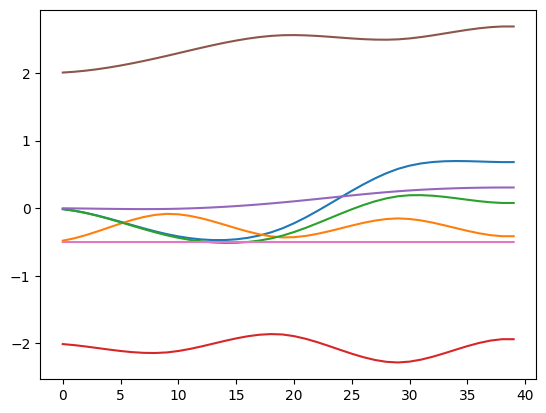

In [29]:
import matplotlib.pyplot as plt
plt.plot(q)
plt.show()

In [30]:
del C